In [1]:
# based on https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/data

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import os
import tensorflow as tf

from imgaug import augmenters as iaa

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../../train2017/'
TEST_PATH = '../../PennFudanPed/TEST/'
MASK_PATH  = 'PedMasks/LIP'

IMAGE_PATH = 'PNGImages/LIP'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [4]:
dataType='train2017'
dataDir='/home/silentium/train2017'
annFile='/home/silentium/Pulpit/annotations/instances_train2017.json'.format(dataDir,dataType)

In [5]:
coco=COCO(annFile)
#coco api https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb


loading annotations into memory...
Done (t=13.06s)
creating index...
index created!


In [6]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
indoor outdoor accessory electronic person animal kitchen food furniture appliance vehicle sports


In [7]:
train_img_ids = next(os.walk(TRAIN_PATH))[2]

#train_mask_ids = next(os.walk(TRAIN_PATH + MASK_PATH))[2]

test_img_ids = next(os.walk(TEST_PATH + 'PNGImages'))[2]

In [17]:
catIds = coco.getCatIds(catNms=['person']);
print(type(catIds))
print(catIds)
imgIds = coco.getImgIds(catIds=catIds );
print(len(imgIds))
imgIds = coco.getImgIds(imgIds = imgIds[2])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)

<class 'list'>
[1]
64115
{'license': 3, 'file_name': '000000524291.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000524291.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-18 09:59:07', 'flickr_url': 'http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg', 'id': 524291}


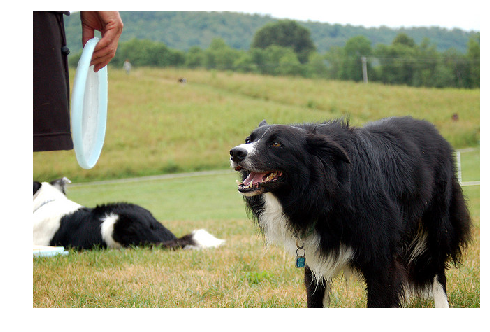

In [26]:
I = io.imread('../../train2017/'+img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()



{'license': 3, 'file_name': '000000524291.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000524291.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-18 09:59:07', 'flickr_url': 'http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg', 'id': 524291}
[191602]


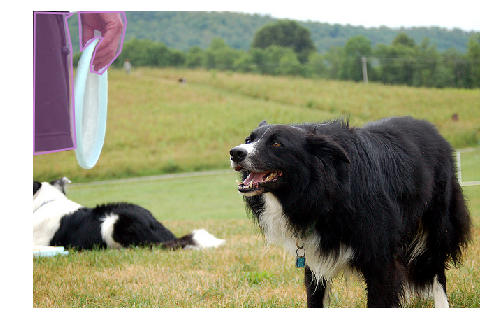

In [28]:
plt.imshow(I); plt.axis('off')
print(img)
annIds = coco.getAnnIds(imgIds=img['id'],catIds=catIds, iscrowd=False)
print(annIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)


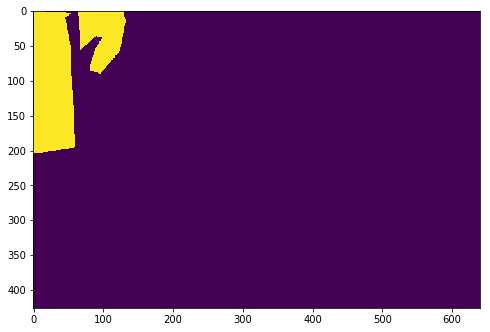

In [29]:
mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])
plt.imshow(mask)

In [6]:
'''

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])
x_aug = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_aug = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
y_aug2 = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
'''

In [6]:
'''

# Get and resize train images and masks
X_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_img_ids), total=len(train_img_ids)):
    path = TRAIN_PATH + IMAGE_PATH + "/"
    try:
        img = imread(path+id_)[:,::IMG_CHANNELS]
        
    except IndexError as e:
        print(e)
        os.remove(path+id_)
    img = np.flip(img, 1)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    #x_aug[n] = img
 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    
    
    path = TRAIN_PATH + MASK_PATH + "/"
    mask_ = imread(path+id_[:-4]+'.png')
   
    
    
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    #y_aug[n]=mask_
    mask = np.maximum(mask, mask_)
    #print(np.unique(mask))
    mask = np.where(mask<0.0001, 0, 1)
    Y_train[n] = mask
'''

Getting and resizing train images and masks ... 


100%|██████████| 30393/30393 [02:25<00:00, 208.98it/s]


In [25]:
# Get and resize train images and masks
X_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_img_ids), total=len(train_img_ids)):
    path = TRAIN_PATH
    try:
        img = imread(path+id_)[:,::IMG_CHANNELS]
        
    except IndexError as e:
        print(e)
        os.remove(path+id_)
    if len(img.shape) == 3:
        img = np.flip(img, 1)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        print(img.size)
        X_train[n] = img
        '''

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)



        path = TRAIN_PATH + MASK_PATH + "/"
        mask_ = imread(path+id_[:-4]+'.png')



        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
        #y_aug[n]=mask_
        mask = np.maximum(mask, mask_)
        #print(np.unique(mask))
        mask = np.where(mask<0.0001, 0, 1)
        Y_train[n] = mask
        '''

Getting and resizing train images and masks ... 



  0%|          | 9/118287 [00:00<22:56, 85.94it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 21/118287 [00:00<21:27, 91.87it/s]

49152
49152
49152



  0%|          | 32/118287 [00:00<20:30, 96.13it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 44/118287 [00:00<19:36, 100.48it/s]

49152
49152
49152
49152



  0%|          | 56/118287 [00:00<18:51, 104.48it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 68/118287 [00:00<18:27, 106.71it/s]

49152
49152
49152
49152



  0%|          | 79/118287 [00:00<18:25, 106.97it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 90/118287 [00:00<18:43, 105.25it/s]

49152
49152
49152
49152



  0%|          | 101/118287 [00:00<18:57, 103.91it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 123/118287 [00:01<19:28, 101.10it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 145/118287 [00:01<18:54, 104.13it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 169/118287 [00:01<18:06, 108.68it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 181/118287 [00:01<17:50, 110.34it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 193/118287 [00:01<19:13, 102.35it/s]

49152
49152
49152
49152
49152
49152



  0%|          | 204/118287 [00:01<18:57, 103.82it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 216/118287 [00:02<18:38, 105.60it/s]

49152
49152
49152
49152
49152
49152



  0%|          | 228/118287 [00:02<18:23, 106.97it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 240/118287 [00:02<17:55, 109.75it/s]

49152
49152
49152
49152
49152
49152



  0%|          | 252/118287 [00:02<18:12, 108.04it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 263/118287 [00:02<18:58, 103.64it/s]

49152
49152
49152
49152
49152
49152



  0%|          | 274/118287 [00:02<18:53, 104.11it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 285/118287 [00:02<18:47, 104.69it/s]

49152
49152
49152
49152
49152
49152
49152



  0%|          | 296/118287 [00:02<18:39, 105.36it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 308/118287 [00:02<18:23, 106.92it/s]

49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 319/118287 [00:03<18:17, 107.50it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 330/118287 [00:03<18:31, 106.08it/s]

49152
49152
49152
49152
49152
49152
49152



  0%|          | 341/118287 [00:03<18:41, 105.17it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 353/118287 [00:03<18:08, 108.36it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 366/118287 [00:03<17:27, 112.52it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 390/118287 [00:03<17:41, 111.12it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 414/118287 [00:03<17:51, 110.03it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 426/118287 [00:03<18:28, 106.30it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 437/118287 [00:04<18:46, 104.62it/s]

49152
49152
49152
49152
49152
49152
49152



  0%|          | 448/118287 [00:04<18:46, 104.63it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 459/118287 [00:04<18:44, 104.76it/s]

49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 470/118287 [00:04<18:53, 103.91it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 482/118287 [00:04<18:17, 107.38it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152


  0%|          | 494/118287 [00:04<18:05, 108.47it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 505/118287 [00:04<18:05, 108.52it/s]

49152
49152
49152
49152
49152
49152
49152



  0%|          | 516/118287 [00:04<18:52, 103.98it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 527/118287 [00:04<19:40, 99.75it/s] 

49152
49152
49152
49152
49152
49152



  0%|          | 538/118287 [00:05<19:33, 100.31it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 549/118287 [00:05<19:14, 102.00it/s]

49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 560/118287 [00:05<19:05, 102.76it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  0%|          | 583/118287 [00:05<18:21, 106.81it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 594/118287 [00:05<18:23, 106.64it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 606/118287 [00:05<18:08, 108.06it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 617/118287 [00:05<18:09, 107.97it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 628/118287 [00:05<18:05, 108.39it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 640/118287 [00:06<17:56, 109.32it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 651/118287 [00:06<17:55, 109.35it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 674/118287 [00:06<18:09, 107.99it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 685/118287 [00:06<18:10, 107.87it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 696/118287 [00:06<18:30, 105.91it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 707/118287 [00:06<18:28, 106.03it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 718/118287 [00:06<18:40, 104.89it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 729/118287 [00:06<18:38, 105.11it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 740/118287 [00:06<18:37, 105.23it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 752/118287 [00:07<18:18, 106.97it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 764/118287 [00:07<17:59, 108.82it/s]

49152
49152
49152
49152
49152
49152
49152
49152
49152
49152
49152



  1%|          | 775/118287 [00:07<18:18, 107.01it/s]

49152
49152
49152
49152
49152
49152


KeyboardInterrupt: 

In [10]:
'''
y_aug = seq.augment_images(y_aug)
x_aug = seq.augment_images(x_aug)
for i in range(len(y_aug)):
    mask = np.maximum(mask, y_aug[i])
    #print(np.unique(mask))
    mask = np.where(mask<0.0001, 0, 1)
    y_aug2[n] = mask
'''

In [11]:
'''
X_train = np.concatenate((X_train, x_aug), axis=0)
Y_train = np.concatenate((Y_train, y_aug2), axis=0)
'''

In [7]:
# Get and resize test images
X_test = np.zeros((len(test_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print(len(test_img_ids))
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_img_ids), total=len(test_img_ids)):
    path = TEST_PATH + 'PNGImages' + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

16
Getting and resizing test images ... 


100%|██████████| 16/16 [00:00<00:00, 99.77it/s]

Done!


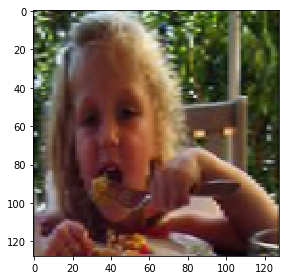

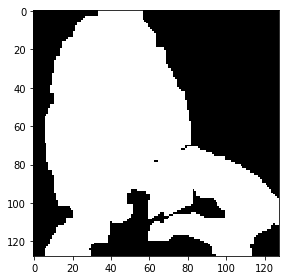

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(train_img_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [3]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [19]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [22]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('../../modele/other_images.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[earlystopper, checkpointer])



Train on 54707 samples, validate on 6079 samples
Epoch 1/50
54707/54707 [==============================] - 162s 3ms/step - loss: 0.3988 - mean_iou: 0.4138 - val_loss: 0.0157 - val_mean_iou: 0.4473

Epoch 00001: val_loss improved from inf to 0.01568, saving model to ../../modele/other_images.h5
Epoch 2/50
54707/54707 [==============================] - 161s 3ms/step - loss: 0.3274 - mean_iou: 0.4701 - val_loss: 0.0104 - val_mean_iou: 0.4884

Epoch 00002: val_loss improved from 0.01568 to 0.01039, saving model to ../../modele/other_images.h5
Epoch 3/50
54707/54707 [==============================] - 161s 3ms/step - loss: 0.2963 - mean_iou: 0.5034 - val_loss: 0.0112 - val_mean_iou: 0.5164

Epoch 00003: val_loss did not improve from 0.01039
Epoch 4/50
54707/54707 [==============================] - 162s 3ms/step - loss: 0.2789 - mean_iou: 0.5276 - val_loss: 0.0126 - val_mean_iou: 0.5370

Epoch 00004: val_loss did not improve from 0.01039
Epoch 5/50
54707/54707 [==============================]

In [9]:
# Predict on train, val and test
model = load_model('../../modele/other_images.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

16/16 [==============================] - 0s 5ms/step


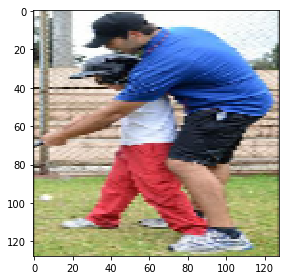

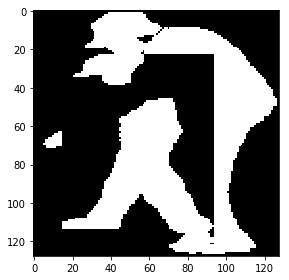

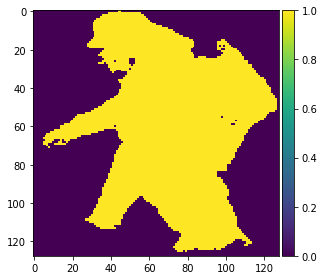

In [10]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()




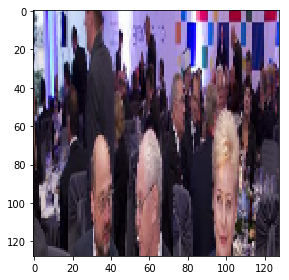

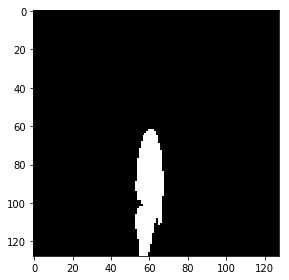

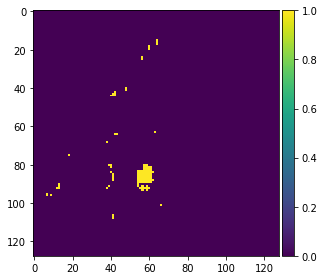

In [11]:


# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]),clim=(0.0, 1.0))
plt.show()
imshow(np.squeeze(preds_val_t[ix]),clim=(0.0, 1.0))
plt.show()



16
30393
16
14
2


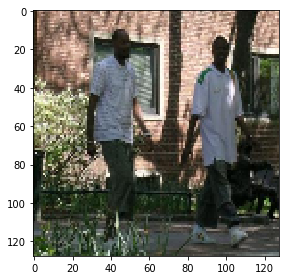

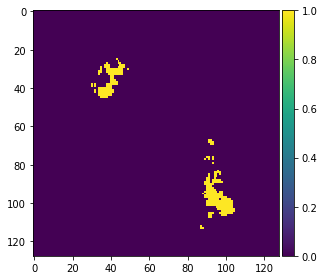

In [13]:
# Perform a sanity check on some random validation samples
print(len(preds_test_t))
ix = random.randint(0, len(preds_test_t)-1)
print(X_train.shape[0])
print(X_test.shape[0])
print(int(X_test.shape[0]*0.9))
print(ix)
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()